In [1]:
import sys
import os
import importlib
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load Data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [8]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [9]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

In [10]:
# c-alpha distances
X = np.hstack((cv_arr, sb_arr[:, 30:], rf161_arr))
y = np.concatenate(q)
print(X.shape, y.shape)

(4150115, 35) (4150115,)


In [11]:
feature_names = []
feature_names.append('Translocation')
feature_names.append('Rotation')
# for r in ("R217", "R223", "R226", "R229", "R232"):
#     for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
#         feature_names.append(f"{r} C$_\\alpha$—{n} C$_\\alpha$")
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        if n.startswith("D"):
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\gamma$")
        else:
            feature_names.append(f"{r} C$_\\zeta$—{n} C$_\\varepsilon$")
for i in ("R223", "R226", "R229"):
    feature_names.append(f"{i}—F161")

# regression

In [12]:
from sklearn.linear_model import Lasso

In [13]:
def run_lasso(data, q, alpha=0.1, fit_intercept=True):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(data, q)
    recon = model.predict(data)
    beta = model.coef_
    intercept = model.intercept_
    score = model.score(data, q)
    return recon, beta, intercept, score

In [14]:
w_arr = np.concatenate(w)
cutoff = 0.2
nsamp = 100000
# sigmoid transform
mid_idx = ((y > cutoff) & (y < 1 - cutoff)).nonzero()[0]
weights = w_arr[mid_idx] * y[mid_idx] * (1 - y[mid_idx])
weights /= np.sum(weights)
idx = np.random.choice(mid_idx, size=min(nsamp,len(mid_idx)), p=weights, replace=False)
logit_q = np.log(y[idx] / (1 - y[idx]))

In [15]:
std_scale = sklearn.preprocessing.StandardScaler()
X_trans = std_scale.fit_transform(X[idx])
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.05)

Translocation: 0.05550221023139339
Rotation: 0.030265719904488828
R223 C$_\zeta$—D164 C$_\gamma$: 0.015732194306442484
R223 C$_\zeta$—D186 C$_\gamma$: 0.010953335836230569
R226 C$_\zeta$—D136 C$_\gamma$: -0.048752724043319644
R226 C$_\zeta$—D151 C$_\gamma$: -0.10603155265162437
R226 C$_\zeta$—D164 C$_\gamma$: 0.028432784797050387
R226 C$_\zeta$—D186 C$_\gamma$: 0.10867205140555598
R229 C$_\zeta$—D164 C$_\gamma$: -0.021470945539074204
R232 C$_\zeta$—E183 C$_\varepsilon$: -0.043693804377523245
R232 C$_\zeta$—D186 C$_\gamma$: -0.23331821199172184
R223—F161: 0.04481763484775022
R229—F161: -0.10291755672705906


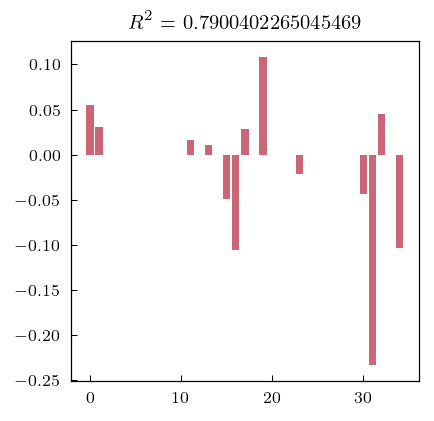

In [16]:
plt.bar(np.arange(X.shape[-1]), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

## plot coefficients

In [17]:
coeffs_all = []
r2_all = []
for a in np.linspace(0.02, 0.30, 15):
    print(f"{a:.2f}")
    _, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=a, fit_intercept=False)
    coeffs_all.append(coeffs)
    r2_all.append(r2)

0.02
0.04
0.06
0.08
0.10
0.12
0.14
0.16
0.18
0.20
0.22
0.24
0.26
0.28
0.30


Text(0, 0.5, 'Coefficients $\\beta$')

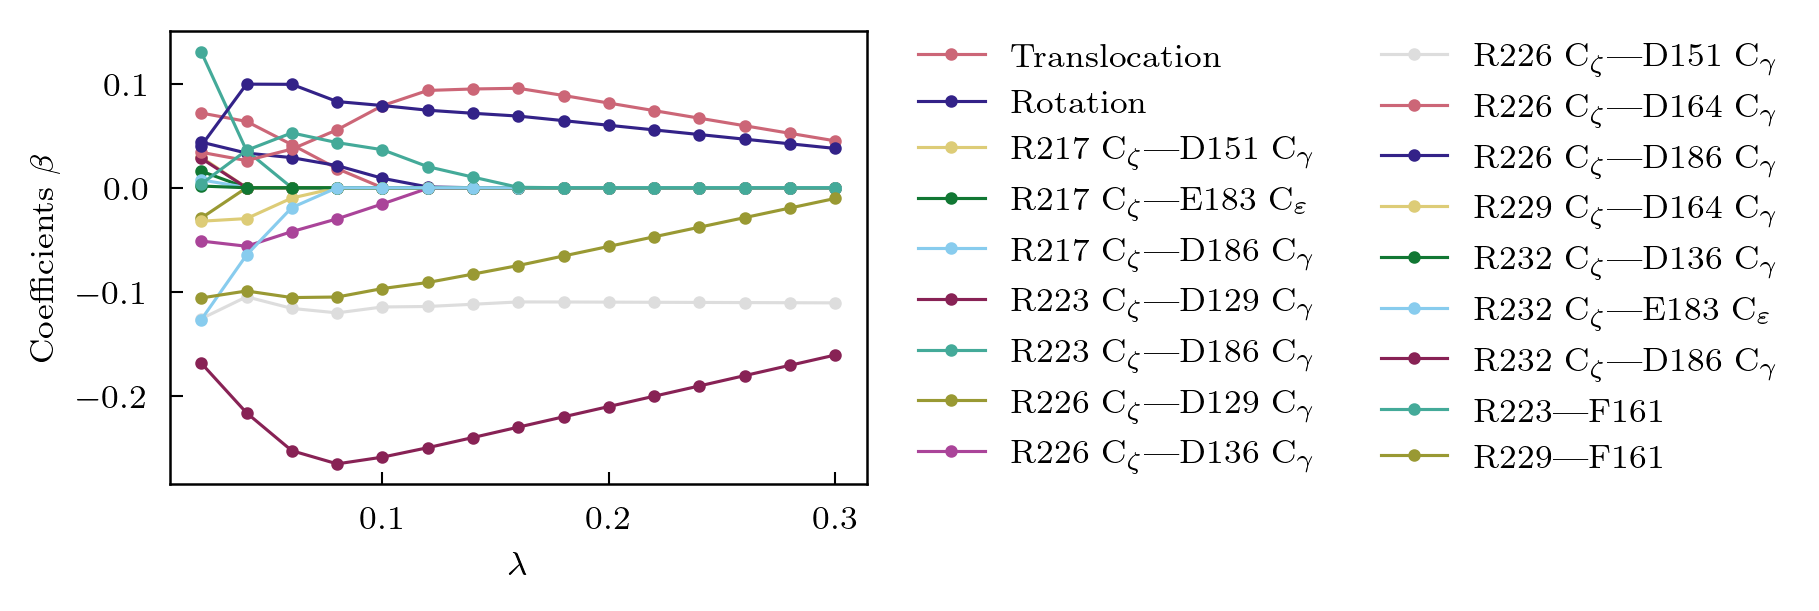

In [19]:
f = plt.figure(figsize=(3, 2), dpi=300)
coeffs_all = np.array(coeffs_all)
alphas = np.linspace(0.02, 0.30, 15)
for i in coeffs_all[0].nonzero()[0]:
    plt.plot(alphas, coeffs_all[:, i], '-o', label=feature_names[i])

pplt.legend(ncol=2, outside='right')
plt.xlabel("$\\lambda$")
plt.ylabel("Coefficients $\\beta$")

(0.0, 1.0)

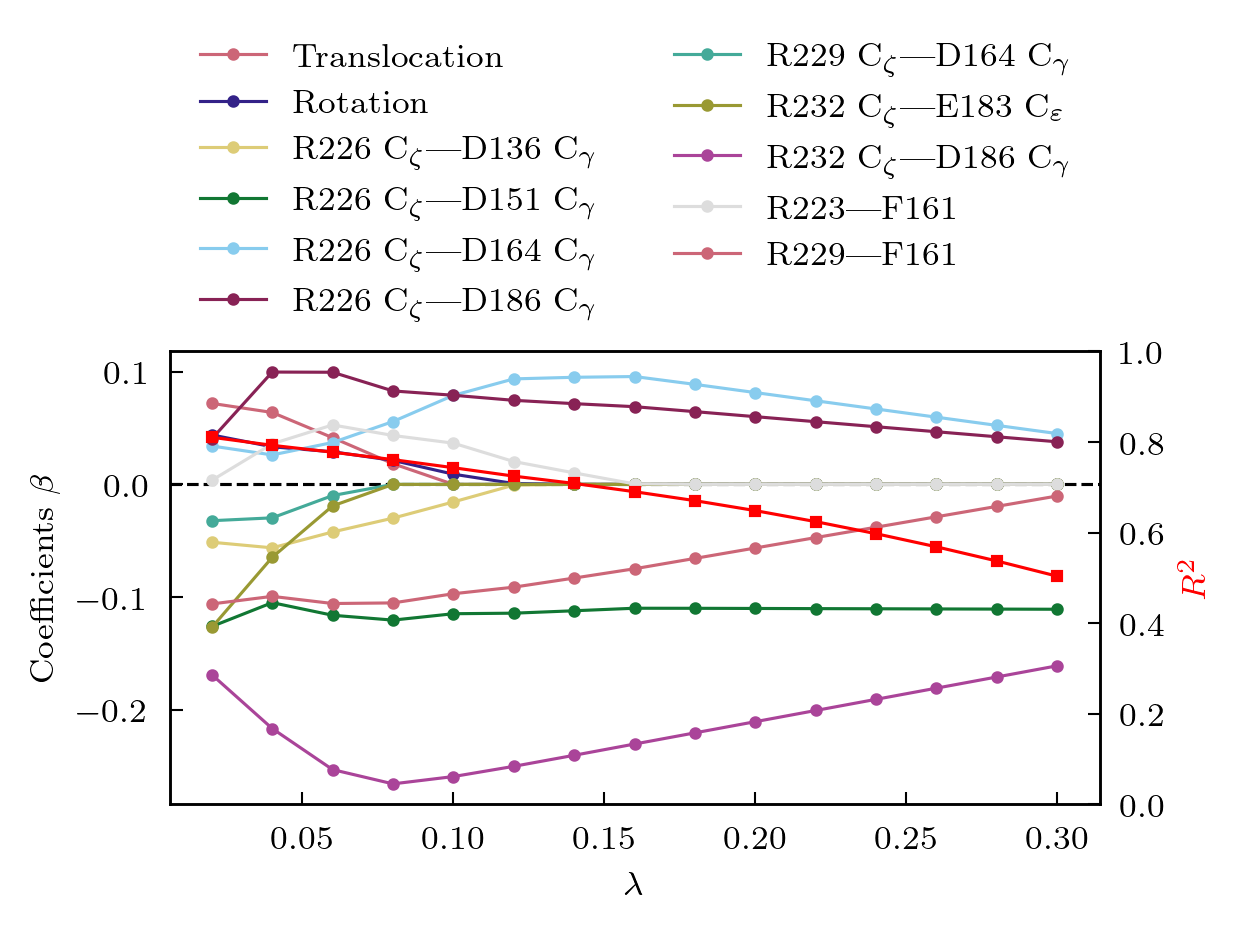

In [22]:
f = plt.figure(figsize=(4, 2), dpi=300)
coeffs_all = np.array(coeffs_all)
alphas = np.linspace(0.02, 0.30, 15)
for i in coeffs_all[2].nonzero()[0]:
    plt.plot(alphas, coeffs_all[:, i], '-o', label=feature_names[i])
plt.xlabel("$\\lambda$")
plt.ylabel("Coefficients $\\beta$")
plt.axhline(ls="--", color='black', zorder=0)
pplt.legend(ncol=2, outside='top')

ax2 = plt.twinx()
ax2.plot(alphas, r2_all, '-s', color='r')
ax2.set_ylabel("$R^2$", color='r')
ax2.set_ylim([0.0, 1.0])

## $\alpha = 0.12$

In [23]:
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.12)

Rotation: 0.0007756170685010894
R226 C$_\zeta$—D136 C$_\gamma$: -0.000621530887548688
R226 C$_\zeta$—D151 C$_\gamma$: -0.11430026597478045
R226 C$_\zeta$—D164 C$_\gamma$: 0.09363344789144697
R226 C$_\zeta$—D186 C$_\gamma$: 0.07460588710373317
R232 C$_\zeta$—D186 C$_\gamma$: -0.25023058328594794
R223—F161: 0.02028371395538022
R229—F161: -0.09121328163210339


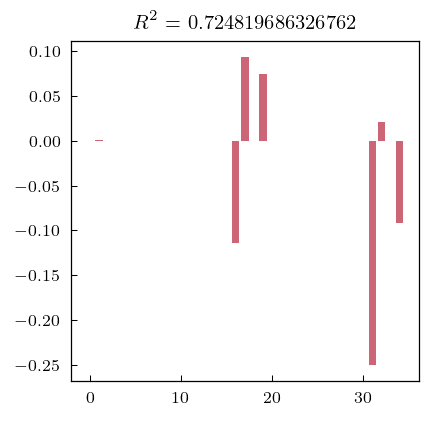

In [24]:
plt.bar(np.arange(X.shape[-1]), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

## $\alpha = 0.08$

In [42]:
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.08)

Translocation: 0.018359664538979387
Rotation: 0.021300333876961987
R226 C$_\zeta$—D136 C$_\gamma$: -0.029946193825408626
R226 C$_\zeta$—D151 C$_\gamma$: -0.12045649646920874
R226 C$_\zeta$—D164 C$_\gamma$: 0.055775477366980526
R226 C$_\zeta$—D186 C$_\gamma$: 0.08293698533688498
R232 C$_\zeta$—D186 C$_\gamma$: -0.26579092543932226
R223—F161: 0.043411564335154314
R229—F161: -0.10519118436998882


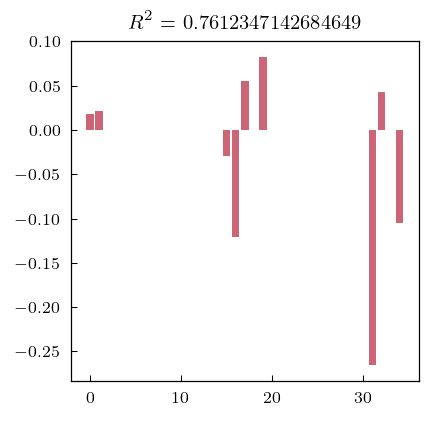

In [43]:
plt.bar(np.arange(X.shape[-1]), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

## $\alpha = 0.06$

In [44]:
pred, coeffs, intercept, r2 = run_lasso(X_trans, logit_q, alpha=0.06)

Translocation: 0.041452436557690917
Rotation: 0.02894654650501435
R226 C$_\zeta$—D136 C$_\gamma$: -0.042228332900378154
R226 C$_\zeta$—D151 C$_\gamma$: -0.1161480252285247
R226 C$_\zeta$—D164 C$_\gamma$: 0.037171514355647646
R226 C$_\zeta$—D186 C$_\gamma$: 0.09952595196274205
R229 C$_\zeta$—D164 C$_\gamma$: -0.00991091625060504
R232 C$_\zeta$—E183 C$_\varepsilon$: -0.01910077857604849
R232 C$_\zeta$—D186 C$_\gamma$: -0.2531245453164181
R223—F161: 0.05277992222648816
R229—F161: -0.10572550934977981


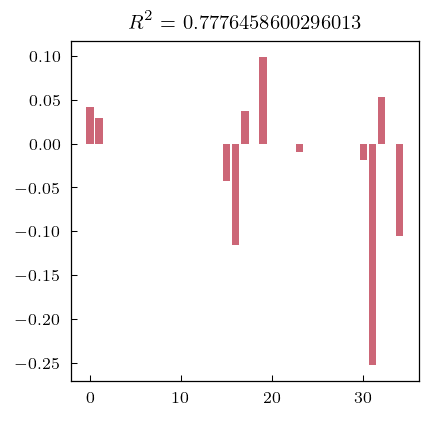

In [45]:
plt.bar(np.arange(X.shape[-1]), coeffs)
plt.title(f"$R^2$ = {r2}")
for i in coeffs.nonzero()[0]:
    print(f"{feature_names[i]}: {coeffs[i]}")

# Correlation matrix

In [ ]:
corr = np.corrcoef(X_trans.T)

In [26]:
corr.shape

(35, 35)

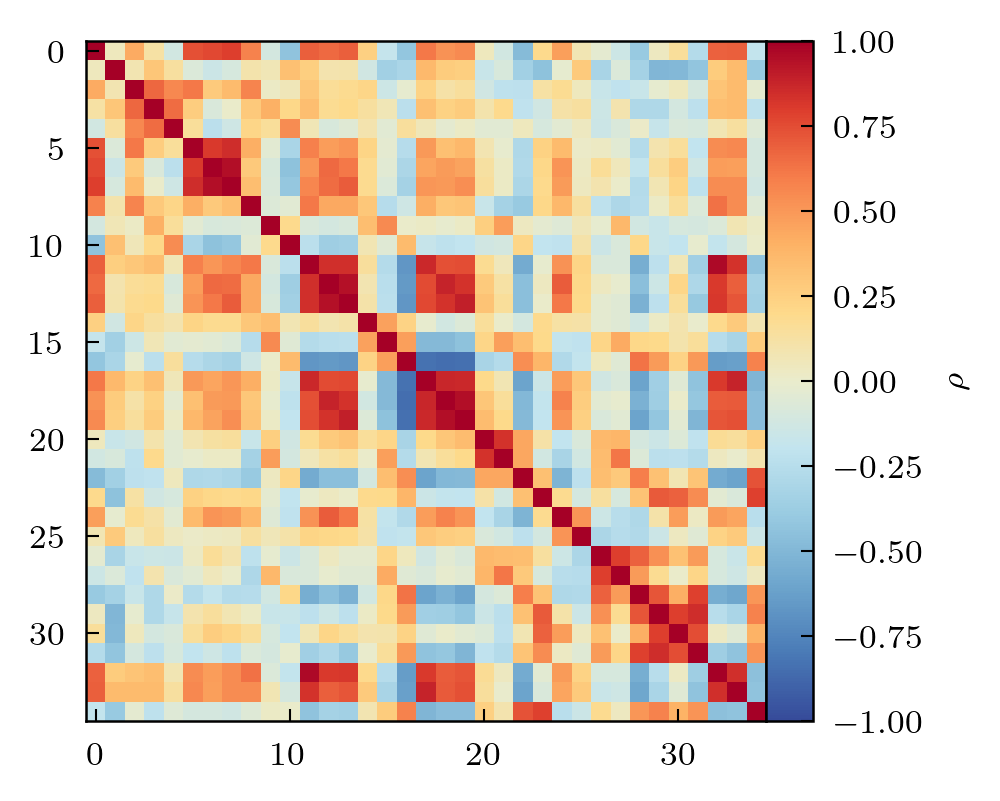

In [41]:
f = plt.figure(dpi=300)
im = pplt.imshow(corr, cmap='diverging', vmin=-1, vmax=1)
pplt.colorbar(im, label="$\\rho$")
ax = f.gca()
xtickslocs = [0, 2, 8, 14, 20, 26, 32]
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xtickslocs))
ax.set_xticks(xtickslocs, labels=['S4', 'R0', 'R1', 'R2', 'R3', 'R4', 'F161'])

# Reduced set of coordinates

S4 (2), R226 variables, R229 variables, R226-F161, R229-F161

In [48]:
X_re = np.hstack((cv_arr, sb_arr[:, 42:54], rf161_arr[:, 1:]))
print(X_re.shape, y.shape)

(4150115, 16) (4150115,)


In [49]:
std_scale = sklearn.preprocessing.StandardScaler()
X_re_std = std_scale.fit_transform(X_re[idx]) # transition region

In [50]:
# perform normal regression
from sklearn.linear_model import LinearRegression

In [52]:
lr_model = LinearRegression()
lr_model.fit(X_re_std, logit_q)
recon = lr_model.predict(X_re_std)
beta = lr_model.coef_
intercept = lr_model.intercept_
score = lr_model.score(X_re_std, logit_q)

Text(0.5, 1.0, '$R^2$ = 0.8454578213500955')

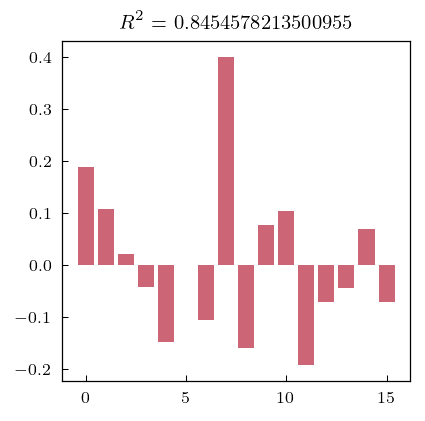

In [54]:
plt.bar(np.arange(X_re.shape[-1]), beta)
plt.title(f"$R^2$ = {score}")

S4 (2), R226-D129,R226-D186, R229-D129, R226-D186, R226-F161, R229-F161

In [55]:
X_re = np.hstack((cv_arr, sb_arr[:, [42, 47, 48, 53]], rf161_arr[:, 1:]))
print(X_re.shape, y.shape)

(4150115, 8) (4150115,)


In [56]:
std_scale = sklearn.preprocessing.StandardScaler()
X_re_std = std_scale.fit_transform(X_re[idx]) # transition region

In [57]:
lr_model = LinearRegression()
lr_model.fit(X_re_std, logit_q)
recon = lr_model.predict(X_re_std)
beta = lr_model.coef_
intercept = lr_model.intercept_
score = lr_model.score(X_re_std, logit_q)

Text(0.5, 1.0, '$R^2$ = 0.800')

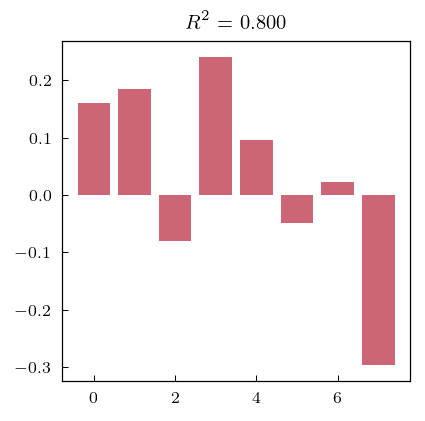

In [60]:
plt.bar(np.arange(X_re.shape[-1]), beta)
plt.title(f"$R^2$ = {score:.3f}")
ax = plt.gca()